# OOD Detection by CAE (MSE)

This notebook demonstrates the process of detecting OOD images by measuring their reconstruction error (i.e., mean-squared error or MSE) after they are passed through a pre-trained convolutional autoencoder (CAE) and comparing it to a pre-computed threshold. Here we assume that a CAE has already been trained to compress ID images (see `train_cae.ipynb` for details), and use that CAE to determine an optimal threshold and encoder/decoder layer for OOD detection. 



## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Navigate to `ood-detection` repository

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Replace [OOD_DETECTION_REPOSITORY] with the correct location
os.chdir('/content/drive/[OOD_DETECTION_REPOSITORY]')
!git pull

Mounted at /content/drive/
Already up to date.


## Build all datasets

All of the analysis in this notebook can be performed using either the `bollworms` or `bollworms-clean` dataset (described in the main report) by changing the value of the `dataset` variable below. Here build ID and OOD dataloaders for the train and test splits from the chosen dataset.

In [24]:
from data_utils.datasets import find_image_files, build_dataset

# Select dataset of interest
dataset = 'bollworms' # ['bollworms', 'bollworms-clean']

# These keyword arguments will be shared by all image datasets
ds_kwargs = {'cache': True, 'image_shape': (256, 256, 3), 'batch_size': 32, 'shuffle_buffer': 512}

# Build training sets of ID and OOD images
train_id_df = find_image_files(f'data/{dataset}-train/ID')
train_id_ds = build_dataset(train_id_df, augment=False, shuffle=False, **ds_kwargs)
train_ood_df = find_image_files(f'data/{dataset}-train/OOD')
train_ood_ds = build_dataset(train_ood_df, augment=False, shuffle=False, **ds_kwargs)

# Build testing sets of ID and OOD images
test_id_df = find_image_files(f'data/{dataset}-test/ID')
test_id_ds = build_dataset(test_id_df, augment=False, shuffle=False, **ds_kwargs)
test_ood_df = find_image_files(f'data/{dataset}-test/OOD')
test_ood_ds = build_dataset(test_ood_df, augment=False, shuffle=False, **ds_kwargs)

Found 7779 image files in folder "data/bollworms-train/ID"
Found 975 image files in folder "data/bollworms-train/OOD"
Found 865 image files in folder "data/bollworms-test/ID"
Found 108 image files in folder "data/bollworms-test/OOD"


## Load pre-trained autoencoder model

In [25]:
from models.autoencoder import Autoencoder

# Select pre-trained model that is appropriate for the dataset
if dataset == 'bollworms':
    autoencoder = Autoencoder.load_model(name='20221130-Benchmark-IDEC')
else:
    autoencoder = Autoencoder.load_model(name='20221202-Benchmark-ID')

## Compute MSE for all datasets

The `Autoencoder` class has an `evaluate_at_layer` method that we can use to compute the loss (here MSE) for all images in our datasets at each layer of the encoder/decoder architecture. Below we construct a `ds_dict` object that is a dictionary whose key-value pairs are the names you want to give each dataset and the datasets themselves. With this object, we can easily build a matching `loss_dicts` object that will give us the loss from each dataset at each layer of interest. This computation can be expensive if the dataset is large, so we frequently want to save this dictionary after computing it so we can reload it later for further analysis.

In [26]:
ds_dict = {'Train ID': train_id_ds, 'Train OOD': train_ood_ds, 'Test ID': test_id_ds, 'Test OOD': test_ood_ds}

loss_dicts = dict()
for layer in range(1, autoencoder.encode_blocks):
    loss_dicts[layer] = {label: autoencoder.evaluate_at_layer(ds, layer) for label, ds in ds_dict.items()}
np.save(f'{autoencoder.folder}/{dataset}_loss_dicts.npy', loss_dicts, allow_pickle=True)

# loss_dicts = np.load(f'{autoencoder.folder}/{dataset}_loss_dicts.npy', allow_pickle=True).tolist()

## Visualize MSE distribution for train dataset at each layer

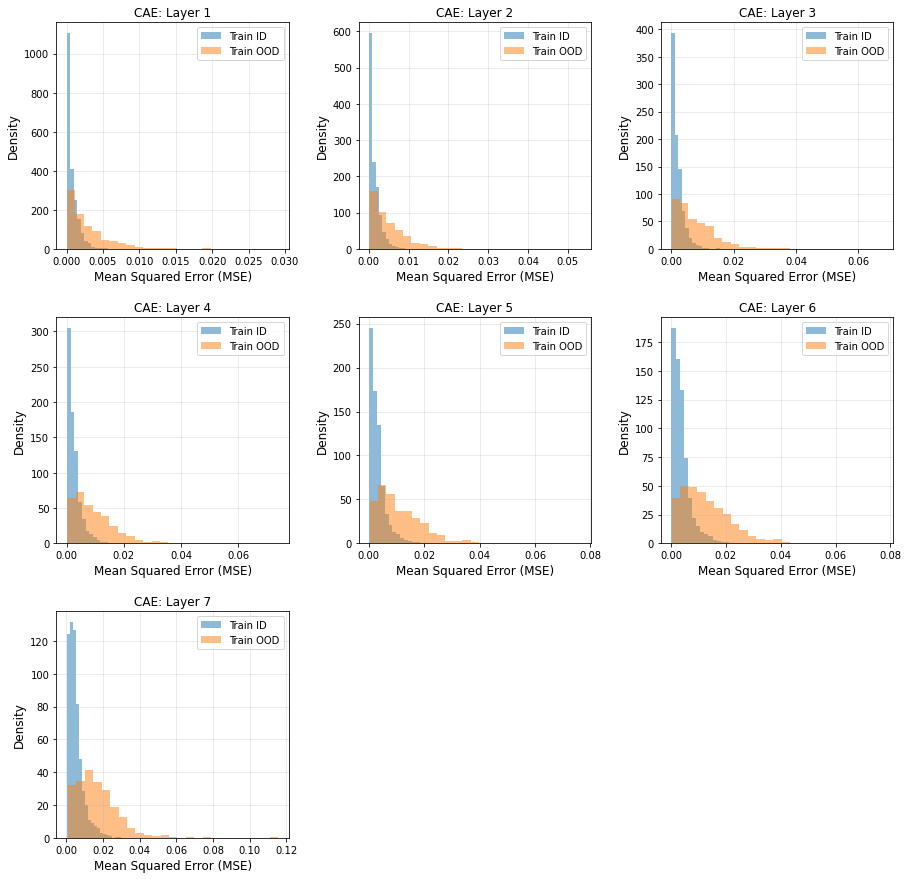

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for ax, (layer, loss_dict) in zip(axes.flatten(), loss_dicts.items()):
    for label, loss in loss_dict.items():
        if 'Train' in label:
            ax.hist(loss, bins=25, alpha=0.5, density=True, label=label)
    ax.set_xlabel('Mean Squared Error (MSE)', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'CAE: Layer {layer}')
    ax.legend()
    ax.grid(alpha=0.3)
fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

## Find optimal threshold and layer using train set

Our goal is the use weighted logistic regression to find the best threshold at each layer. We use weighted logistic regression to compute class probabilities rather than using the MSE scores directly because there is strong class imbalance in our train and test sets (train set is approximately 90% ID and 10% OOD). Here we fit a weighted logistic regression model to the MSE scores in the train set at each layer, and compute the threshold that maximizes the macro-averaged F1 score. We will then use the layer and threshold that gives us the highest macro-averaged F1 score overall for our final analysis on the test set.

In [28]:
from analysis.classifiers import get_auroc, get_f1_maximizing_threshold, get_classification_report
from sklearn.linear_model import LogisticRegression

best_max_f1_score = 0
for layer, loss_dict in loss_dicts.items():

    # Fit weighted logistic regression model to the training data
    logit_model = LogisticRegression(penalty='none', class_weight='balanced')
    x_train = np.concatenate([loss_dict['Train ID'], loss_dict['Train OOD']]).reshape(-1, 1)
    y_train = np.concatenate([np.ones_like(loss_dict['Train ID']), np.zeros_like(loss_dict['Train OOD'])])
    logit_model.fit(x_train, y_train)

    # Compute model-predicted ID probabilities, which we treat as our new anomaly 
    # detection scores. Then use these scores to find the threshold that maximizes 
    # macro-averaged F1.
    scores_train_id = logit_model.predict_proba(x_train[y_train == 1])[:, 1]
    scores_train_ood = logit_model.predict_proba(x_train[y_train == 0])[:, 1]
    threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)
    print(f'Layer {layer}: Max F1 score on train set = {max_f1_score:.3f}, ID probability threshold = {threshold:.3f}')

    # Save this model if it is our best so far
    if max_f1_score > best_max_f1_score:
        best_max_f1_score = max_f1_score
        best_logit_model = logit_model
        best_threshold = threshold
        best_layer = layer

# Report best layer
print('')
print(f'Best layer: {best_layer}')
print('')

Layer 1: Max F1 score on train set = 0.715, ID probability threshold = 0.221
Layer 2: Max F1 score on train set = 0.720, ID probability threshold = 0.236
Layer 3: Max F1 score on train set = 0.743, ID probability threshold = 0.193
Layer 4: Max F1 score on train set = 0.737, ID probability threshold = 0.284
Layer 5: Max F1 score on train set = 0.741, ID probability threshold = 0.297
Layer 6: Max F1 score on train set = 0.744, ID probability threshold = 0.281
Layer 7: Max F1 score on train set = 0.755, ID probability threshold = 0.280

Best layer: 7



## Use optimal layer and threshold to evaluate on test set

Now that we have chosen our optimal layer and threshold using the train set, we can finally evaluate our OOD detection performance on the test set. The output of this code cell was used to produce the primary table of results in our main report.

In [29]:
# Compute model-predicted ID probabilities on the test set using our best model.
best_loss_dict = loss_dicts[best_layer]
x_test = np.concatenate([best_loss_dict['Test ID'], best_loss_dict['Test OOD']]).reshape(-1, 1)
y_test = np.concatenate([np.ones_like(best_loss_dict['Test ID']), np.zeros_like(best_loss_dict['Test OOD'])])
scores_test_id = best_logit_model.predict_proba(x_test[y_test == 1])[:, 1]
scores_test_ood = best_logit_model.predict_proba(x_test[y_test == 0])[:, 1]

# Compute and report all classifier metrics of interest 
auc = get_auroc(scores_test_id, scores_test_ood)
class_report, conf_matrix = get_classification_report(scores_test_id, scores_test_ood, best_threshold)
per_class_accuracy = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
tn, fp, fn, tp = conf_matrix.ravel()

print(f'Classification report on test set [layer: {layer}, Score: MSE]:')
print('')
print(class_report)
print(f'OOD accuracy: {per_class_accuracy[0]:.3f}')
print(f' ID accuracy: {per_class_accuracy[1]:.3f}')
print('')
print('Breakdown:', {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp})
print('')
print(f'AUC: {auc:.3f}')
print('')

Classification report on test set [layer: 7, Score: MSE]:

              precision    recall  f1-score   support

      OOD: 0      0.456     0.435     0.445       108
       ID: 1      0.930     0.935     0.933       865

    accuracy                          0.880       973
   macro avg      0.693     0.685     0.689       973
weighted avg      0.877     0.880     0.879       973

OOD accuracy: 0.435
 ID accuracy: 0.935

Breakdown: {'TN': 47, 'FP': 61, 'FN': 56, 'TP': 809}

AUC: 0.827



## Visualize test set performance

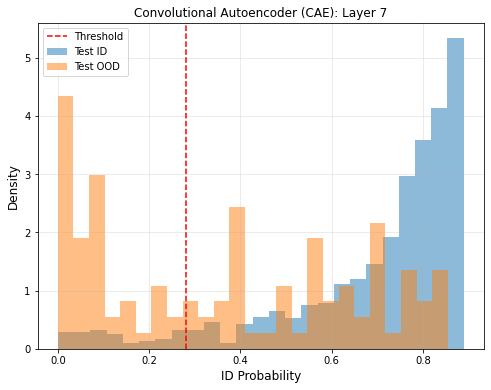

In [30]:
# First in terms of ID probabilities from weighted logistic regression model
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(scores_test_id, bins=25, alpha=0.5, density=True, label='Test ID')
ax.hist(scores_test_ood, bins=25, alpha=0.5, density=True, label='Test OOD')
ax.axvline(best_threshold, color='r', linestyle='--', label='Threshold')
ax.set_xlabel('ID Probability', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Convolutional Autoencoder (CAE): Layer {best_layer}')
ax.legend()
ax.grid(alpha=0.3)

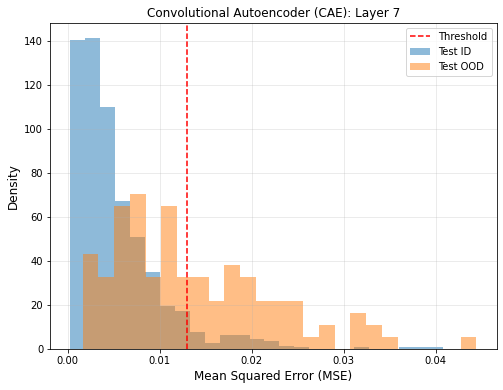

In [31]:
# Then on the original scale in terms of MSE values
logit = lambda p: np.log(p/(1-p))
best_threshold_MSE = ((logit(best_threshold) - best_logit_model.intercept_)/logit_model.coef_[0][0])[0]
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(best_loss_dict['Test ID'], bins=25, alpha=0.5, density=True, label='Test ID')
ax.hist(best_loss_dict['Test OOD'], bins=25, alpha=0.5, density=True, label='Test OOD')
ax.axvline(best_threshold_MSE, color='r', linestyle='--', label='Threshold')
ax.set_xlabel('Mean Squared Error (MSE)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Convolutional Autoencoder (CAE): Layer {best_layer}')
ax.legend()
ax.grid(alpha=0.3)

## Evaluate on external OOD datasets

If present in the `ood-detection/data` folder, we can also evaluate our classifier on the `stanford_dogs` and `flowers102` datasets.

In [13]:
# Randomly sample this many images from each external OOD dataset below
num_images = 3000

# Build stanford dogs dataset
stanford_dogs_df = find_image_files('data/stanford_dogs/Images/*')
stanford_dogs_df = stanford_dogs_df.sample(frac=1, random_state=297).iloc[:num_images]
stanford_dogs_ds = build_dataset(stanford_dogs_df, augment=False, shuffle=False, **ds_kwargs)

# Build flowers102 dataset
flowers102_df = find_image_files('data/flowers102/jpg')
flowers102_df = flowers102_df.sample(frac=1, random_state=297).iloc[:num_images]
flowers102_ds = build_dataset(flowers102_df, augment=False, shuffle=False, **ds_kwargs)

# Combine them into one external dataset dictionary object
external_ds_dict = {'Dogs': stanford_dogs_ds, 'Flowers': flowers102_ds}

Found 20580 image files in folder "data/stanford_dogs/Images/*"
Found 1620 image files in folder "data/flowers102/jpg"


In [32]:
# Compute the loss for all images in each of these datasets at the best layer.
external_loss_dict = {label: autoencoder.evaluate_at_layer(ds, best_layer) for label, ds in external_ds_dict.items()}

for label, loss in external_loss_dict.items():

    # Compute model-predicted ID probabilities on the test set using our best model.
    scores_external_ood = best_logit_model.predict_proba(loss.reshape(-1, 1))[:, 1]

    # Compute the fraction of images in this dataset that our model would label as OOD.
    external_ood_accuracy = 1.0 - np.mean(scores_external_ood > best_threshold)
    print(f'{label} (OOD) accuracy: {external_ood_accuracy:.3f}')

Dogs (OOD) accuracy: 0.720
Flowers (OOD) accuracy: 0.906
